In [1]:
# -*- coding: utf-8 -*-

import cv2 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import datetime as dt
from scipy.spatial import distance as dist
sns.set_style('ticks')
%matplotlib inline


/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
def add_border(tag, tag_shape, white_width = 1, black_width = 2):
    
    """Add black and white border to barcode tag.
        
        Parameters
        ----------
        tag : 1-D array_like
            Flattened barcode tag.
        tag_shape : tuple of int
            Shape of the barcode tag without a border.
        white_width : int
            Width of white border.
        black_width : int
            Width of black border.
            
        Returns
        -------
        bordered_tag : 1-D array
            Returns tag with border added flattened to 1-D array.
        """
    
    tag = np.asarray(tag)
    tag = tag.reshape(tag_shape)

    black_border = np.zeros((tag_shape[0]+(2*white_width)+(2*black_width),tag_shape[1]+(2*white_width)+(2*black_width)))
    white_border = np.ones((tag_shape[0]+(2*white_width),tag_shape[1]+(2*white_width)))
    
    white_border[white_width:tag_shape[0]+white_width,white_width:tag_shape[1]+white_width] = tag
    black_border[black_width:tag_shape[0]+(2*white_width)+black_width, black_width:tag_shape[1]+(2*white_width)+black_width] = white_border

    tag = black_border
    bordered_tag = tag.reshape((1,tag.shape[0]*tag.shape[1]))
    tag_shape = black_border.shape
    return  tag_shape, bordered_tag

In [3]:
master_list = np.load("/Users/Jake/opal/master_list.npy")
master_list = master_list[:600]
master_list.shape

(600, 25)

In [4]:
barcode_size = (7,7)
barcodes = []
for barcode in master_list:
    tag_shape, barcode = add_border(barcode, (5,5), white_width = 1, black_width = 0)
    barcode = barcode.reshape(tag_shape)
    barcode = cv2.resize(barcode, barcode_size, interpolation = cv2.INTER_AREA)
    #plt.imshow(barcode, cmap = 'gray', interpolation = 'None')
    #plt.show()
    barcode = barcode.flatten()
    barcodes.append(barcode)
barcodes = np.array(barcodes)
#barcodes[barcodes == 0] = 0
#barcodes[barcodes == 1] = 255
barcodes

array([[ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       ..., 
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.]])

In [5]:
ID_list = []
for i in range(len(barcodes)/4):
    ID = [i,i,i,i]
    ID_list.append(ID)
ID_array = np.array(ID_list)
IDs = ID_array.flatten()
IDs

array([  0,   0,   0,   0,   1,   1,   1,   1,   2,   2,   2,   2,   3,
         3,   3,   3,   4,   4,   4,   4,   5,   5,   5,   5,   6,   6,
         6,   6,   7,   7,   7,   7,   8,   8,   8,   8,   9,   9,   9,
         9,  10,  10,  10,  10,  11,  11,  11,  11,  12,  12,  12,  12,
        13,  13,  13,  13,  14,  14,  14,  14,  15,  15,  15,  15,  16,
        16,  16,  16,  17,  17,  17,  17,  18,  18,  18,  18,  19,  19,
        19,  19,  20,  20,  20,  20,  21,  21,  21,  21,  22,  22,  22,
        22,  23,  23,  23,  23,  24,  24,  24,  24,  25,  25,  25,  25,
        26,  26,  26,  26,  27,  27,  27,  27,  28,  28,  28,  28,  29,
        29,  29,  29,  30,  30,  30,  30,  31,  31,  31,  31,  32,  32,
        32,  32,  33,  33,  33,  33,  34,  34,  34,  34,  35,  35,  35,
        35,  36,  36,  36,  36,  37,  37,  37,  37,  38,  38,  38,  38,
        39,  39,  39,  39,  40,  40,  40,  40,  41,  41,  41,  41,  42,
        42,  42,  42,  43,  43,  43,  43,  44,  44,  44,  44,  4

In [6]:
def crop(src, pt1, pt2):
    
    """ Returns a cropped version of src """
    
    cropped = src[pt1[1]:pt2[1], pt1[0]:pt2[0]]
    
    return cropped

"""def order_points(pts):
	# initialzie a list of coordinates that will be ordered
	# such that the first entry in the list is the top-left,
	# the second entry is the top-right, the third is the
	# bottom-right, and the fourth is the bottom-left
	rect = np.zeros((4, 2), dtype = 'float32')
 
	# the top-left point will have the smallest sum, whereas
	# the bottom-right point will have the largest sum
	s = pts.sum(axis = 1)
	rect[0] = pts[np.argmin(s)]
	rect[2] = pts[np.argmax(s)]
 
	# now, compute the difference between the points, the
	# top-right point will have the smallest difference,
	# whereas the bottom-left will have the largest difference
	diff = np.diff(pts, axis = 1)
	rect[1] = pts[np.argmin(diff)]
	rect[3] = pts[np.argmax(diff)]
 
	# return the ordered coordinates
	return rect"""

def order_points(pts):
    # sort the points based on their x-coordinates
    xSorted = pts[np.argsort(pts[:, 0]), :]
 
    # grab the left-most and right-most points from the sorted
    # x-roodinate points
    leftMost = xSorted[:2, :]
    rightMost = xSorted[2:, :]
 
    # now, sort the left-most coordinates according to their
    # y-coordinates so we can grab the top-left and bottom-left
    # points, respectively
    leftMost = leftMost[np.argsort(leftMost[:, 1]), :]
    (tl, bl) = leftMost
 
    # now that we have the top-left coordinate, use it as an
    # anchor to calculate the Euclidean distance between the
    # top-left and right-most points; by the Pythagorean
    # theorem, the point with the largest distance will be
    # our bottom-right point
    D = dist.cdist(tl[np.newaxis], rightMost, "euclidean")[0]
    (br, tr) = rightMost[np.argsort(D)[::-1], :]
    
    # return the coordinates in top-left, top-right,
    # bottom-right, and bottom-left order
    return np.array([tl, tr, br, bl], dtype="float32")

def four_point_transform(image, pts):
    # obtain a consistent order of the points and unpack them
    # individually
    rect = pts
    (tl, tr, br, bl) = rect
 
    # compute the width of the new image, which will be the
    # maximum distance between bottom-right and bottom-left
    # x-coordiates or the top-right and top-left x-coordinates
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    #maxWidth = max(int(widthA), int(widthB))
 
    # compute the height of the new image, which will be the
    # maximum distance between the top-right and bottom-right
    # y-coordinates or the top-left and bottom-left y-coordinates
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    #maxHeight = max(int(heightA), int(heightB))
 
    # now that we have the dimensions of the new image, construct
    # the set of destination points to obtain a "birds eye view",
    # (i.e. top-down view) of the image, again specifying points
    # in the top-left, top-right, bottom-right, and bottom-left
    # order
    maxSide = max(int(widthA), int(widthB), int(heightA), int(heightB))
    dst = np.array([
        [0, 0],
        [maxSide - 1, 0],
        [maxSide - 1, maxSide - 1],
        [0, maxSide - 1]], dtype = "float32")
 
    # compute the perspective transform matrix and then apply it
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxSide, maxSide))
 
    # return the warped image
    return warped

def corr2_coeff(A,B):
    # Rowwise mean of input arrays & subtract from input arrays themeselves
    A_mA = np.subtract(A, A.mean(1)[:,None])
    B_mB = np.subtract(B, B.mean(1)[:,None])

    # Sum of squares across rows
    ssA = np.square(A_mA).sum(1)
    ssB = np.square(B_mB).sum(1)

    # Finally get corr coeff
    return np.divide(np.dot(A_mA,B_mB.T), np.sqrt(np.dot(ssA[:,None],ssB[None])))

def unit_vector(vector):
	
	""" Returns the unit vector of the vector.  """
	
	return np.divide(vector, np.linalg.norm(vector))

def angle(v1, v2, degrees = True):
	
	"""Returns the angle between vectors 'v1' and 'v2'.
		
		Parameters
		----------
		v1 : 1-D array_like
			N-dimensional vector.
		v2 : 1-D array_like
			N-dimensional vector.
		degrees : bool, default = True
			Return angle in degrees.
			
		Returns
		-------
		angle : float
			Angle between v1 and v2.
		
		"""
	
	v1_u = unit_vector(v1)
	v2_u = unit_vector(v2)
	angle = np.arccos(np.dot(v1_u, v2_u))
	if np.isnan(angle):
		if (v1_u == v2_u).all():
			return 0.0
		else:
			return np.pi
	if degrees == True:
		angle = np.degrees(angle)
	return angle

In [8]:
#pt1 = (1200,500)
#pt2 = (2800,1500)
#cap = cv2.VideoCapture("/Users/Jake/Google Drive/test.mov") 
#pt1 = (0,0)
#pt2 = (1080,1500)
#cap = cv2.VideoCapture("/Users/Jake/Google Drive/VID_20160719_103625.mp4") 
cap = cv2.VideoCapture("/Users/Jake/Downloads/VID_20160722_115829 copy 4.mp4") 


#cap = cv2.VideoCapture("/Users/Jake/Google Drive/CLIP0000075_000.mov")
#pt1 = (1000,0)
#pt2 = (3160,2160)

parea_list = []

resize_f = 1
n_frames = 0

best_values = []
matched_list = []
area_list = []
# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc('A','V','C','1')
#out = cv2.VideoWriter('output.mp4',fourcc, 15.0, (1960, 1080), True)
t0 = dt.datetime.now()
convex_bool_list = []



n_cnts_start = 0
n_cnts_area = 0
n_cnts_poly = 0
n_cnts_predict = 0
n_cnts_pixels = 0
n_cnts_pixels = 0

font = cv2.FONT_HERSHEY_SIMPLEX

flat_len = barcode_size[0]*barcode_size[1]    
while cap.isOpened():  
    
    ret, img = cap.read()
    
    if ret:
        n_tags = 0
        contours_list = []
        features_list = []
        pixel_values = []
        warped_list = []

        cropped = img

        #cropped = crop(img, pt1, pt2)
        #cropped = cv2.resize(cropped, (0,0), None, fx = 0.33, fy = 0.33, interpolation = cv2.INTER_LINEAR)
        #cropped = cv2.resize(cropped, (0,0), None, fx = 3, fy = 3, interpolation = cv2.INTER_LINEAR)

        display_img = cropped.copy()
        
        _, gray, _ = cv2.split(cropped)
        blurred = cv2.GaussianBlur(gray, (81,81), 1)
        resized = blurred #cv2.resize(blurred, (0,0), None, fx = resize_f, fy = resize_f, interpolation = cv2.INTER_AREA)
        thresh = cv2.adaptiveThreshold(resized, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 101, 41)
        #ret, thresh = cv2.threshold(resized, 100, 200, cv2.THRESH_BINARY)
        contour_image, contours, hierarchy = cv2.findContours(thresh.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        #cv2.drawContours(display_img, contours, -1, (0,0,255), 3)
        edge_thresh = 1
        maxx_thresh = cropped.shape[1] - edge_thresh
        maxy_thresh = cropped.shape[0] - edge_thresh
        for cnt in contours:

            if cnt.shape[0] >= 4:
                
                area = cv2.contourArea(cnt, True)
                n_cnts_start += 1

                if -800*resize_f > area > -8000*resize_f: 
                    cnt_shape = cnt.shape
                    cnt_reshape = cnt.reshape((cnt_shape[0], cnt_shape[2]))
                    cnt_x = cnt_reshape[:,0]
                    cnt_y = cnt_reshape[:,1]
                    flat = cnt.flatten()
                    edge_zero = np.sum(flat <= edge_thresh)
                    edge_maxx = np.sum(cnt_x >= maxx_thresh)
                    edge_maxy = np.sum(cnt_y >= maxy_thresh)

                    if edge_zero == 0 and edge_maxx == 0 and edge_maxy == 0:
                        
                        peri_cnt = cv2.arcLength(cnt, True)

                        approx = cv2.approxPolyDP(cnt, 0.07 * peri_cnt, True)
                    
                        cv2.drawContours(display_img, [approx], -1, (0,0,255), 3)

                        poly_area = cv2.contourArea(approx, True)
                        n_cnts_area += 1

                        if len(approx) == 4 and -800 > poly_area > -8000 and cv2.isContourConvex(approx):

                            cv2.drawContours(display_img, [approx], -1, (0,255,255), 3)
                            #convex = cv2.convexHull(cnt)
                            #peri_convex = cv2.arcLength(convex, True)
                            #convex_area = cv2.contourArea(convex)
                            #carea = area/convex_area
                            #peri_area = peri_cnt/area

                            #parea = area/poly_area
                            #parea_list.append(parea)

                            #(x,y),radius = cv2.minEnclosingCircle(cnt)
                            #circ_area = np.pi * radius**2
                            #circ_area = area/circ_area

                            #features_list = [[0,0,0,0],[peri_area, carea, parea, circ_area]]
                            #features = np.array(features_list)
                            #prediction = clf.predict(features)

                            n_cnts_poly += 1

                            if True:#prediction[1] == 1:#
                                
                                cnt_shape = approx.shape
                                pts = approx.reshape((cnt_shape[0], cnt_shape[-1]))

                                pts = order_points(pts)
                                (tl, tr, br, bl) = pts
                                warped = four_point_transform(gray, pts/resize_f)
                                warped_list.append(warped)
                                pixels = warped
                                #pixels_centered = np.subtract(pixels, pixels.mean())
                                #pixels_standard = np.divide(pixels_centered, pixels.std())
                                resize_warp = cv2.resize(pixels, barcode_size, interpolation = cv2.INTER_AREA)
                                #resize_warp = resize_warp[1:-1,1:-1]

                                pixels = resize_warp.flatten()
                                pixel_values.append(pixels)

                                #pixels_centered = np.subtract(pixels, pixels.mean())
                                #pixels_standard = np.divide(pixels_centered, pixels.std())
                                #test = np.repeat([pixels_standard], barcodes.shape[0], axis = 0)
                                #matched = np.multiply(test, barcodes)
                                correlation = corr2_coeff(barcodes, pixels.reshape((1,flat_len)))
                                #matched_sum = np.mean(matched, axis = 1)
                                #matched_list.append(matched_sum)
                                best_value = np.max(correlation)
                                
                                n_cnts_predict += 1
                                best_values.append(best_value)

                                if best_value > 0.1:
                                    best_values.append(best_value)
                                    contours_list.append(cnt/resize_f)
                                    #area_list.append(area)
                                    rad = 10
                                    pts = pts/resize_f
                                    area_list.append(area)
                                    best_index = np.argmax(correlation)
                                    
                                    ID = IDs[best_index]
                                    centroid = tuple(pts.mean(0))
                                    rotate_test = best_index % 4
                                    if rotate_test == 3:
                                        edge = tuple(np.mean([tl, tr], axis = 0))
                                    if rotate_test == 0:
                                        edge = tuple(np.mean([tl, bl], axis = 0))
                                    if rotate_test == 1:
                                        edge = tuple(np.mean([br, bl], axis = 0))
                                    if rotate_test == 2:
                                        edge = tuple(np.mean([br, tr], axis = 0))
                                    cv2.drawContours(display_img, [approx/resize_f], -1, (0,255,0), 3)

                                    #cv2.circle(display_img,tuple(pts[0]), rad, (255,0,0), -1)
                                    #cv2.circle(display_img,tuple(pts[1]), rad, (0,255,0), -1)
                                    #cv2.circle(display_img,tuple(pts[2]), rad, (0,0,255), -1)
                                    #cv2.circle(display_img,tuple(pts[3]), rad, (255,0,255), -1)
                                    #cv2.circle(display_img,centroid, rad, (0,255,0), -1)
                                    
                                    vector = np.subtract(edge, centroid)
                                    vector_angle = angle(vector, [1,0])
                                    angle_str = '%.0f' % vector_angle
                                    #cv2.putText(display_img,str(ID),centroid, font, 1,(0,0,0),15,cv2.LINE_AA)
                                    #cv2.putText(display_img,str(ID),centroid, font, 1,(255,255,255),3,cv2.LINE_AA)
                                    
                                    cv2.line(display_img, centroid, edge, (0,0,255), 10)
                                    cv2.putText(display_img,angle_str,centroid, font, 1,(0,0,0),15,cv2.LINE_AA)
                                    cv2.putText(display_img,angle_str,centroid, font, 1,(255,255,255),3,cv2.LINE_AA)

                                    #cv2.putText(display_img,str(best_value)[:4],centroid, font, 1,(0,0,0),15,cv2.LINE_AA)
                                    #cv2.putText(display_img,str(best_value)[:4],centroid, font, 1,(255,255,255),3,cv2.LINE_AA)

                                    n_cnts_pixels += 1
                                    n_tags += 1
        pixel_values = np.array(pixel_values)

        cv2.putText(display_img,"Number of Barcodes: " + str(n_tags),(5,30), font, 1,(0,0,0),15,cv2.LINE_AA)
        cv2.putText(display_img,"Number of Barcodes: " + str(n_tags),(5,30), font, 1,(255,255,255),3,cv2.LINE_AA)

        display_img = cv2.resize(display_img, (1960,1080), None)
        #display_img = cv2.resize(display_img, (1000,1000), None)

        #display_img = cv2.resize(display_img, (0,0), None, fx = 0.01, fy = 0.01)

        thresh = cv2.resize(thresh, (1960,1080), None)

        #thresh = cv2.resize(thresh, (640,360), None)
        #thresh = cv2.cvtColor(thresh, cv2.COLOR_GRAY2BGR)
        #display_img[-360:,-640:] = thresh

        #out.write(display_img)
        cv2.imshow('Video', display_img)
        #cv2.imshow('gray', gray)
        #cv2.imshow("thresh", thresh)
        n_frames += 1
    else:
        break
    if cv2.waitKey(1) & 0xFF == 27:
        break
        
cap.release()
#out.release()
cv2.destroyAllWindows()

for i in range(5):
    cv2.waitKey(1)
    
t1 = dt.datetime.now()

dtime = t1 - t0
dtime = dtime.total_seconds()
fps = n_frames/dtime
print fps

1.32573754933


In [ ]:
best_index

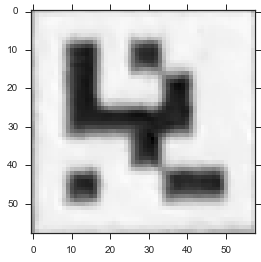

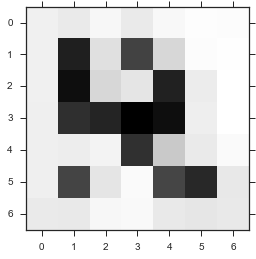

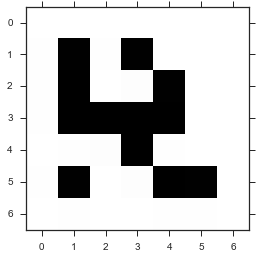

In [10]:
plt.imshow(warped, cmap = 'gray', interpolation = 'none')
plt.show()
plt.imshow(resize_warp, cmap = 'gray', interpolation = 'none')
plt.show()
plt.imshow(barcodes[best_index].reshape(barcode_size), cmap = 'gray', interpolation = 'none')
plt.show()

In [42]:
7 % 4

3

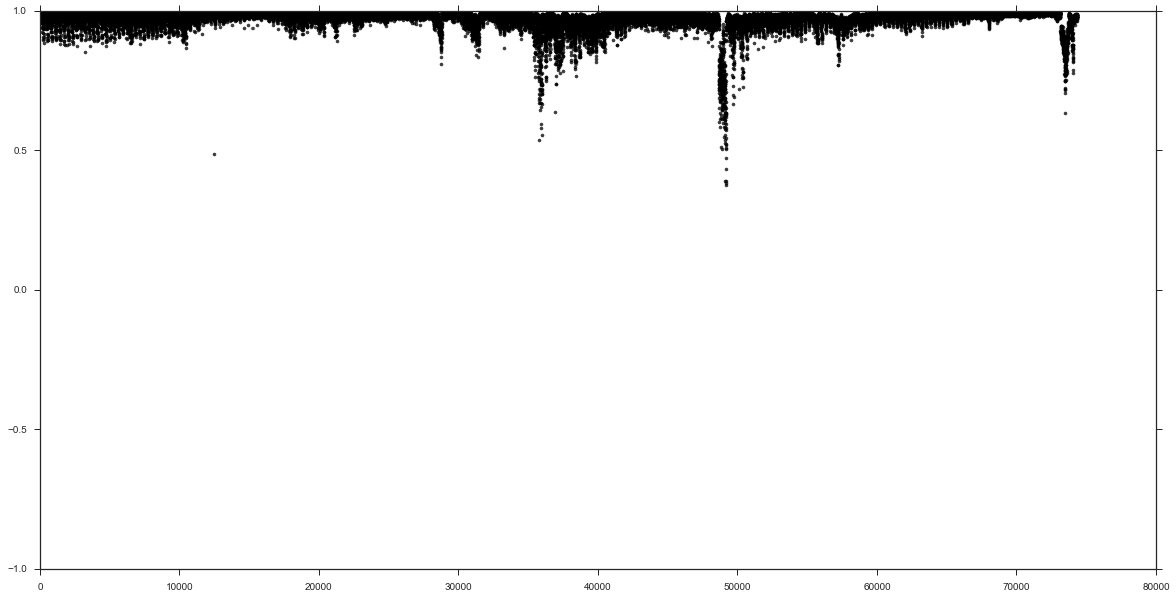

In [13]:
plt.figure(figsize = (20,10))
plt.plot(np.arange(len(best_values)), best_values, 'k.', alpha = 0.5)
plt.ylim(-1,1)
plt.show()